## Chapter 7 - Markov Chain Monte Carlo

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

%matplotlib inline

plt.style.use('seaborn-white')
color = '#87ceeb'

### Prior
We will again use a beta distribution to describe our prior beliefs about the values of $\theta$.  However, it is now written as a function that takes values of $\theta$ and returns probabilties.  We will also do this for our likelihood and our posterior.  This allows us to repeatedly call these for arbitrary parameter (i.e., $\theta$) values as we wander the the parameter space during our MCMC sampling.

In [31]:
a = 1
b = 1

def prior(theta):
    return beta.pdf(theta, a, b)

### Data
This constructs a set of flip outcomes.  Specify the number of heads (i.e., `n_heads`) and the number of tails (i.e., `n_tails`).  There are three scenarios prepared:

1. 1 flip that comes up heads
2. 4 flips, 1 of which comes up heads (25% heads)
3. 40 flips, 10 of which come up heads (25% heads)

In [32]:
# example 1
n_heads = 1
n_tails = 0

# example 2
#n_heads = 1
#n_tails = 3

# example 3
n_heads = 10
n_tails = 30

data = np.repeat([1, 0], [n_heads, n_tails])

### Likelihood
Here again, we have rewritten our usual Bernoulli likelihood as a function that returns the likelihood for a given $\theta$ and given set of data.

In [33]:
def likelihood(theta, n_flips, n_heads):
    return (theta**n_heads) * ( (1-theta)**(n_flips - n_heads) )

### Exact Inference
Here we calculate the posterior exactly.  This will allow us to easily visualize how well our MCMC approximation is performing.  Again, we have written this as a function.

In [34]:
post_a = n_heads + a
post_b = n_tails + b

def posterior(theta):
    return beta.pdf(theta, post_a, post_b)

### Approximate Inference via MCMC
Here we approximate the posterior using the Metropolis algorithm.  This routine is **for illustrative purposes only**.  It is written for clarity and is slow.

Sampling parameters (number of samples, number of chains, width of the proposal distribution) are here to be tweaked.  Note that the alternative values for the width of the proposal distribution are intended to yield poor sampling performance.

In [35]:
# Metropolis parameters
# number of samples
n_samples = 5000
n_chains = 2

# width of proposal distribution
sigma = 0.25
#sigma = 0.01
#sigma = 10

# this will store our list of credible parameter values
# that generated by the Metropolis algorithm
theta_trace = np.zeros([n_chains, n_samples])
theta_trace[:,0] = np.random.uniform(size=n_chains)

# let's keep track of how many proposed jumps we accept
n_accept = 0

for i in range(n_chains):
    for j in range(1, n_samples):

        # retrieve the current value of theta from our list
        current_theta = theta_trace[i,j-1]
        # unnormalized posterior of the current value of theta
        theta_p = likelihood(current_theta, (n_heads+n_tails), n_heads) * prior(current_theta)
        # generate the proposal
        theta_star = current_theta + np.random.normal(0, sigma, 1)[0]
        # unnormalized posterior of the proposed value of theta
        theta_star_p = likelihood(theta_star, (n_heads+n_tails), n_heads) * prior(theta_star)

        # determine whether to accept proposal
        if (theta_star_p / theta_p) > np.random.uniform(size=1)[0]:
            theta_trace[i,j] = theta_star
            n_accept += 1
        else:
            theta_trace[i,j] = current_theta

Ok, so now we have wandered around the parameter space a bit.  Let's see how many of our proposals were accepted.

In [36]:
print('# of proposals:\t\t\t'+str(n_chains * n_samples))
print('# of proposals accepted:\t'+str(n_accept))
print('% of proposals accepted:\t'+str(100*(n_accept/(n_chains * n_samples))))

# of proposals:			10000
# of proposals accepted:	3226
% of proposals accepted:	32.26


### Visualize
Plot the prior, the likelihood, and the posterior.

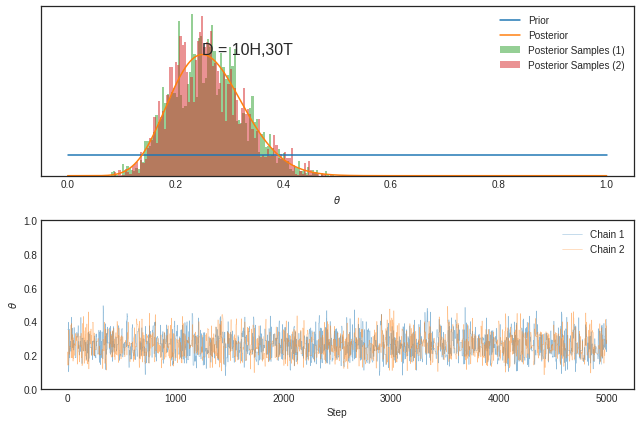

In [37]:
fig, ax = plt.subplots(2, figsize=(9, 6))
#plt.figure(figsize=(9, 12))
xs = np.linspace(0, 1, 1000)
ax[0].plot(xs, prior(xs), label='Prior')
ax[0].plot(xs, posterior(xs), label='Posterior')
for i in range(n_chains):
    ax[0].hist(theta_trace[i,:], alpha=.5, bins=100, density=True, label='Posterior Samples ('+str(i+1)+')')

ax[0].text(.25, np.max(posterior(xs)), 'D = %sH,%sT' % (n_heads, n_tails), size=16)

ax[0].set(xlabel=r'$\theta$')
ax[0].yaxis.set(ticks=())
#ax[0].legend(['Prior', 'Posterior (exact)', 'Posterior Samples']);
ax[0].legend();

for i in range(n_chains):
    ax[1].plot(theta_trace[i,:], alpha=.5, linewidth=.5, label='Chain '+str(i+1))
ax[1].set(xlabel='Step', ylabel=r'$\theta$', ylim=[0,1])
ax[1].legend()
fig.tight_layout();